In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [30]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [31]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [32]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [33]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [71]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    Qs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, # GAN
                                                                   labels=rates)) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    aloss2 = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [72]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [73]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [74]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)),
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [75]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [76]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [77]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [78]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with minibatches
            batch = memory.sample(batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:11.0000 R:11.0000 rate:0.0220 aloss:1.3880 dloss:0.4891 aloss2:2.4176 exploreP:0.9989
Episode:1 meanR:18.5000 R:26.0000 rate:0.0520 aloss:1.3871 dloss:0.4813 aloss2:2.4926 exploreP:0.9963
Episode:2 meanR:16.6667 R:13.0000 rate:0.0260 aloss:1.3884 dloss:0.4724 aloss2:2.5947 exploreP:0.9951
Episode:3 meanR:17.2500 R:19.0000 rate:0.0380 aloss:1.3857 dloss:0.4663 aloss2:2.6574 exploreP:0.9932
Episode:4 meanR:19.8000 R:30.0000 rate:0.0600 aloss:1.3851 dloss:0.4552 aloss2:2.7872 exploreP:0.9902
Episode:5 meanR:20.3333 R:23.0000 rate:0.0460 aloss:1.3842 dloss:0.4409 aloss2:2.9437 exploreP:0.9880
Episode:6 meanR:19.2857 R:13.0000 rate:0.0260 aloss:1.3867 dloss:0.4351 aloss2:3.0361 exploreP:0.9867
Episode:7 meanR:18.2500 R:11.0000 rate:0.0220 aloss:1.3844 dloss:0.4288 aloss2:3.1315 exploreP:0.9857
Episode:8 meanR:19.4444 R:29.0000 rate:0.0580 aloss:1.3878 dloss:0.4211 aloss2:3.2227 exploreP:0.9828
Episode:9 meanR:26.8000 R:93.0000 rate:0.1860 aloss:1.3864 dloss:0.3971 aloss2:3.5

Episode:80 meanR:20.7037 R:40.0000 rate:0.0800 aloss:1.3928 dloss:0.2246 aloss2:12.3228 exploreP:0.8472
Episode:81 meanR:20.6585 R:17.0000 rate:0.0340 aloss:1.3922 dloss:0.2210 aloss2:12.3926 exploreP:0.8457
Episode:82 meanR:20.5904 R:15.0000 rate:0.0300 aloss:1.3921 dloss:0.2221 aloss2:12.4392 exploreP:0.8445
Episode:83 meanR:20.6190 R:23.0000 rate:0.0460 aloss:1.3922 dloss:0.2202 aloss2:12.4243 exploreP:0.8426
Episode:84 meanR:20.5647 R:16.0000 rate:0.0320 aloss:1.3925 dloss:0.2222 aloss2:12.6212 exploreP:0.8412
Episode:85 meanR:20.5116 R:16.0000 rate:0.0320 aloss:1.3909 dloss:0.2220 aloss2:12.6322 exploreP:0.8399
Episode:86 meanR:20.4483 R:15.0000 rate:0.0300 aloss:1.3936 dloss:0.2237 aloss2:12.7344 exploreP:0.8387
Episode:87 meanR:20.6250 R:36.0000 rate:0.0720 aloss:1.3926 dloss:0.2247 aloss2:12.7616 exploreP:0.8357
Episode:88 meanR:20.6180 R:20.0000 rate:0.0400 aloss:1.3920 dloss:0.2224 aloss2:12.9635 exploreP:0.8340
Episode:89 meanR:20.5222 R:12.0000 rate:0.0240 aloss:1.3919 dlos

Episode:159 meanR:27.1900 R:29.0000 rate:0.0580 aloss:1.3948 dloss:0.2181 aloss2:13.9025 exploreP:0.6781
Episode:160 meanR:27.1400 R:12.0000 rate:0.0240 aloss:1.3950 dloss:0.2202 aloss2:13.7881 exploreP:0.6773
Episode:161 meanR:26.9600 R:22.0000 rate:0.0440 aloss:1.3943 dloss:0.2174 aloss2:13.8754 exploreP:0.6759
Episode:162 meanR:26.9200 R:15.0000 rate:0.0300 aloss:1.3937 dloss:0.2179 aloss2:13.9129 exploreP:0.6749
Episode:163 meanR:26.9400 R:20.0000 rate:0.0400 aloss:1.3946 dloss:0.2204 aloss2:13.9084 exploreP:0.6736
Episode:164 meanR:26.6500 R:13.0000 rate:0.0260 aloss:1.3949 dloss:0.2193 aloss2:13.8754 exploreP:0.6727
Episode:165 meanR:26.7200 R:24.0000 rate:0.0480 aloss:1.3961 dloss:0.2170 aloss2:13.8206 exploreP:0.6711
Episode:166 meanR:26.6700 R:10.0000 rate:0.0200 aloss:1.3957 dloss:0.2170 aloss2:13.8578 exploreP:0.6704
Episode:167 meanR:26.5200 R:12.0000 rate:0.0240 aloss:1.3952 dloss:0.2162 aloss2:13.9644 exploreP:0.6696
Episode:168 meanR:26.5300 R:14.0000 rate:0.0280 aloss:1

Episode:239 meanR:17.7200 R:13.0000 rate:0.0260 aloss:1.3966 dloss:0.2152 aloss2:14.0059 exploreP:0.5944
Episode:240 meanR:17.5800 R:12.0000 rate:0.0240 aloss:1.3955 dloss:0.2249 aloss2:13.8092 exploreP:0.5937
Episode:241 meanR:17.4500 R:10.0000 rate:0.0200 aloss:1.3963 dloss:0.2111 aloss2:13.8477 exploreP:0.5931
Episode:242 meanR:17.3800 R:17.0000 rate:0.0340 aloss:1.3953 dloss:0.2186 aloss2:13.9112 exploreP:0.5921
Episode:243 meanR:17.3600 R:16.0000 rate:0.0320 aloss:1.3962 dloss:0.2163 aloss2:13.8923 exploreP:0.5911
Episode:244 meanR:17.3500 R:11.0000 rate:0.0220 aloss:1.3955 dloss:0.2136 aloss2:13.8858 exploreP:0.5905
Episode:245 meanR:17.3500 R:15.0000 rate:0.0300 aloss:1.3950 dloss:0.2171 aloss2:14.0337 exploreP:0.5896
Episode:246 meanR:17.2700 R:13.0000 rate:0.0260 aloss:1.3942 dloss:0.2172 aloss2:14.0052 exploreP:0.5889
Episode:247 meanR:17.1700 R:10.0000 rate:0.0200 aloss:1.3961 dloss:0.2131 aloss2:13.9622 exploreP:0.5883
Episode:248 meanR:17.2800 R:29.0000 rate:0.0580 aloss:1

Episode:319 meanR:15.6300 R:10.0000 rate:0.0200 aloss:1.3981 dloss:0.2215 aloss2:13.8527 exploreP:0.5265
Episode:320 meanR:15.7000 R:18.0000 rate:0.0360 aloss:1.3975 dloss:0.2172 aloss2:13.9652 exploreP:0.5255
Episode:321 meanR:15.7500 R:18.0000 rate:0.0360 aloss:1.3975 dloss:0.2199 aloss2:14.0209 exploreP:0.5246
Episode:322 meanR:15.7400 R:14.0000 rate:0.0280 aloss:1.3980 dloss:0.2141 aloss2:13.9646 exploreP:0.5239
Episode:323 meanR:15.7600 R:11.0000 rate:0.0220 aloss:1.3985 dloss:0.2179 aloss2:13.8621 exploreP:0.5233
Episode:324 meanR:15.8200 R:23.0000 rate:0.0460 aloss:1.3978 dloss:0.2171 aloss2:14.0050 exploreP:0.5221
Episode:325 meanR:15.7800 R:14.0000 rate:0.0280 aloss:1.3986 dloss:0.2127 aloss2:14.0670 exploreP:0.5214
Episode:326 meanR:15.5100 R:14.0000 rate:0.0280 aloss:1.3990 dloss:0.2145 aloss2:14.1365 exploreP:0.5207
Episode:327 meanR:15.4700 R:9.0000 rate:0.0180 aloss:1.3953 dloss:0.2164 aloss2:14.2343 exploreP:0.5203
Episode:328 meanR:15.5100 R:13.0000 rate:0.0260 aloss:1.

Episode:399 meanR:14.7200 R:19.0000 rate:0.0380 aloss:1.4004 dloss:0.2142 aloss2:14.0676 exploreP:0.4689
Episode:400 meanR:14.7000 R:17.0000 rate:0.0340 aloss:1.4021 dloss:0.2176 aloss2:14.1111 exploreP:0.4682
Episode:401 meanR:14.5900 R:11.0000 rate:0.0220 aloss:1.4001 dloss:0.2171 aloss2:13.9865 exploreP:0.4677
Episode:402 meanR:14.5900 R:13.0000 rate:0.0260 aloss:1.3997 dloss:0.2161 aloss2:13.9599 exploreP:0.4671
Episode:403 meanR:14.5600 R:11.0000 rate:0.0220 aloss:1.3973 dloss:0.2126 aloss2:14.2378 exploreP:0.4666
Episode:404 meanR:14.6500 R:20.0000 rate:0.0400 aloss:1.4013 dloss:0.2129 aloss2:13.9494 exploreP:0.4656
Episode:405 meanR:14.5400 R:9.0000 rate:0.0180 aloss:1.4013 dloss:0.2158 aloss2:14.3338 exploreP:0.4652
Episode:406 meanR:14.5600 R:16.0000 rate:0.0320 aloss:1.3988 dloss:0.2181 aloss2:14.0177 exploreP:0.4645
Episode:407 meanR:14.5400 R:10.0000 rate:0.0200 aloss:1.3981 dloss:0.2161 aloss2:14.1041 exploreP:0.4640
Episode:408 meanR:14.7100 R:26.0000 rate:0.0520 aloss:1.

Episode:478 meanR:12.4400 R:9.0000 rate:0.0180 aloss:1.4002 dloss:0.2162 aloss2:13.9576 exploreP:0.4280
Episode:479 meanR:12.2500 R:10.0000 rate:0.0200 aloss:1.4009 dloss:0.2172 aloss2:14.0994 exploreP:0.4276
Episode:480 meanR:12.2100 R:11.0000 rate:0.0220 aloss:1.4010 dloss:0.2123 aloss2:13.9680 exploreP:0.4271
Episode:481 meanR:12.2300 R:12.0000 rate:0.0240 aloss:1.4002 dloss:0.2168 aloss2:13.8668 exploreP:0.4266
Episode:482 meanR:12.2800 R:14.0000 rate:0.0280 aloss:1.4029 dloss:0.2133 aloss2:14.0783 exploreP:0.4260
Episode:483 meanR:12.2200 R:9.0000 rate:0.0180 aloss:1.4009 dloss:0.2178 aloss2:14.0870 exploreP:0.4256
Episode:484 meanR:12.1800 R:11.0000 rate:0.0220 aloss:1.4000 dloss:0.2176 aloss2:13.9438 exploreP:0.4252
Episode:485 meanR:12.1800 R:10.0000 rate:0.0200 aloss:1.4022 dloss:0.2152 aloss2:14.0553 exploreP:0.4248
Episode:486 meanR:12.1600 R:11.0000 rate:0.0220 aloss:1.4014 dloss:0.2158 aloss2:14.0266 exploreP:0.4243
Episode:487 meanR:12.1600 R:12.0000 rate:0.0240 aloss:1.4

Episode:559 meanR:12.0900 R:9.0000 rate:0.0180 aloss:1.4030 dloss:0.2153 aloss2:14.2571 exploreP:0.3883
Episode:560 meanR:12.0800 R:11.0000 rate:0.0220 aloss:1.4013 dloss:0.2192 aloss2:14.0896 exploreP:0.3879
Episode:561 meanR:12.0700 R:18.0000 rate:0.0360 aloss:1.4017 dloss:0.2145 aloss2:14.1310 exploreP:0.3872
Episode:562 meanR:12.1100 R:13.0000 rate:0.0260 aloss:1.4021 dloss:0.2147 aloss2:14.0756 exploreP:0.3867
Episode:563 meanR:12.1100 R:11.0000 rate:0.0220 aloss:1.4020 dloss:0.2124 aloss2:14.0297 exploreP:0.3863
Episode:564 meanR:12.1900 R:17.0000 rate:0.0340 aloss:1.4022 dloss:0.2126 aloss2:14.1084 exploreP:0.3857
Episode:565 meanR:12.2000 R:10.0000 rate:0.0200 aloss:1.4026 dloss:0.2126 aloss2:14.2189 exploreP:0.3853
Episode:566 meanR:12.2000 R:10.0000 rate:0.0200 aloss:1.4040 dloss:0.2195 aloss2:14.1079 exploreP:0.3849
Episode:567 meanR:12.1600 R:9.0000 rate:0.0180 aloss:1.4038 dloss:0.2086 aloss2:14.1089 exploreP:0.3846
Episode:568 meanR:12.1900 R:12.0000 rate:0.0240 aloss:1.4

Episode:638 meanR:12.0500 R:15.0000 rate:0.0300 aloss:1.4026 dloss:0.2160 aloss2:14.0211 exploreP:0.3537
Episode:639 meanR:12.0300 R:10.0000 rate:0.0200 aloss:1.4043 dloss:0.2137 aloss2:14.0377 exploreP:0.3534
Episode:640 meanR:12.0300 R:11.0000 rate:0.0220 aloss:1.4020 dloss:0.2111 aloss2:14.1872 exploreP:0.3530
Episode:641 meanR:12.0000 R:9.0000 rate:0.0180 aloss:1.4021 dloss:0.2082 aloss2:14.0564 exploreP:0.3527
Episode:642 meanR:12.0100 R:11.0000 rate:0.0220 aloss:1.4016 dloss:0.2148 aloss2:14.0652 exploreP:0.3523
Episode:643 meanR:12.0200 R:11.0000 rate:0.0220 aloss:1.4049 dloss:0.2136 aloss2:14.1176 exploreP:0.3519
Episode:644 meanR:12.1300 R:22.0000 rate:0.0440 aloss:1.4023 dloss:0.2187 aloss2:14.2759 exploreP:0.3512
Episode:645 meanR:12.1200 R:10.0000 rate:0.0200 aloss:1.4010 dloss:0.2102 aloss2:13.9026 exploreP:0.3508
Episode:646 meanR:12.0800 R:13.0000 rate:0.0260 aloss:1.4019 dloss:0.2131 aloss2:14.0080 exploreP:0.3504
Episode:647 meanR:12.0500 R:15.0000 rate:0.0300 aloss:1.

Episode:719 meanR:12.2300 R:14.0000 rate:0.0280 aloss:1.4024 dloss:0.2161 aloss2:14.1085 exploreP:0.3218
Episode:720 meanR:12.3200 R:19.0000 rate:0.0380 aloss:1.4032 dloss:0.2146 aloss2:14.1857 exploreP:0.3212
Episode:721 meanR:12.2900 R:11.0000 rate:0.0220 aloss:1.4028 dloss:0.2129 aloss2:14.2146 exploreP:0.3208
Episode:722 meanR:12.2500 R:9.0000 rate:0.0180 aloss:1.4032 dloss:0.2155 aloss2:14.1809 exploreP:0.3205
Episode:723 meanR:12.2600 R:10.0000 rate:0.0200 aloss:1.4013 dloss:0.2115 aloss2:14.1932 exploreP:0.3202
Episode:724 meanR:12.3200 R:23.0000 rate:0.0460 aloss:1.4030 dloss:0.2162 aloss2:14.1590 exploreP:0.3195
Episode:725 meanR:12.3000 R:10.0000 rate:0.0200 aloss:1.4019 dloss:0.2100 aloss2:14.0756 exploreP:0.3192
Episode:726 meanR:12.2900 R:11.0000 rate:0.0220 aloss:1.4048 dloss:0.2094 aloss2:14.1381 exploreP:0.3189
Episode:727 meanR:12.2800 R:10.0000 rate:0.0200 aloss:1.4057 dloss:0.2136 aloss2:14.1476 exploreP:0.3186
Episode:728 meanR:12.2500 R:13.0000 rate:0.0260 aloss:1.

Episode:798 meanR:11.5900 R:11.0000 rate:0.0220 aloss:1.4032 dloss:0.2108 aloss2:14.3240 exploreP:0.2949
Episode:799 meanR:11.5800 R:10.0000 rate:0.0200 aloss:1.4032 dloss:0.2124 aloss2:14.2964 exploreP:0.2946
Episode:800 meanR:11.6100 R:16.0000 rate:0.0320 aloss:1.4042 dloss:0.2129 aloss2:14.3695 exploreP:0.2942
Episode:801 meanR:11.5800 R:9.0000 rate:0.0180 aloss:1.4029 dloss:0.2064 aloss2:14.1739 exploreP:0.2939
Episode:802 meanR:11.5600 R:11.0000 rate:0.0220 aloss:1.4044 dloss:0.2142 aloss2:14.2575 exploreP:0.2936
Episode:803 meanR:11.5900 R:15.0000 rate:0.0300 aloss:1.4026 dloss:0.2099 aloss2:14.1544 exploreP:0.2932
Episode:804 meanR:11.5600 R:10.0000 rate:0.0200 aloss:1.4027 dloss:0.2098 aloss2:14.3482 exploreP:0.2929
Episode:805 meanR:11.5300 R:9.0000 rate:0.0180 aloss:1.4036 dloss:0.2104 aloss2:14.1761 exploreP:0.2926
Episode:806 meanR:11.5400 R:11.0000 rate:0.0220 aloss:1.4023 dloss:0.2112 aloss2:14.3199 exploreP:0.2923
Episode:807 meanR:11.5300 R:8.0000 rate:0.0160 aloss:1.40

Episode:879 meanR:10.6700 R:9.0000 rate:0.0180 aloss:1.4024 dloss:0.2102 aloss2:14.4186 exploreP:0.2718
Episode:880 meanR:10.6600 R:10.0000 rate:0.0200 aloss:1.4042 dloss:0.2137 aloss2:14.2136 exploreP:0.2715
Episode:881 meanR:10.7300 R:16.0000 rate:0.0320 aloss:1.4020 dloss:0.2046 aloss2:14.2932 exploreP:0.2711
Episode:882 meanR:10.7200 R:10.0000 rate:0.0200 aloss:1.4020 dloss:0.2114 aloss2:14.3535 exploreP:0.2709
Episode:883 meanR:10.6600 R:9.0000 rate:0.0180 aloss:1.4050 dloss:0.2148 aloss2:14.3523 exploreP:0.2706
Episode:884 meanR:10.6800 R:10.0000 rate:0.0200 aloss:1.4046 dloss:0.2103 aloss2:14.1789 exploreP:0.2704
Episode:885 meanR:10.6400 R:10.0000 rate:0.0200 aloss:1.4052 dloss:0.2102 aloss2:14.4177 exploreP:0.2701
Episode:886 meanR:10.5400 R:10.0000 rate:0.0200 aloss:1.4035 dloss:0.2082 aloss2:14.2594 exploreP:0.2699
Episode:887 meanR:10.5300 R:9.0000 rate:0.0180 aloss:1.4041 dloss:0.2094 aloss2:14.4581 exploreP:0.2696
Episode:888 meanR:10.5400 R:11.0000 rate:0.0220 aloss:1.40

Episode:960 meanR:10.8600 R:13.0000 rate:0.0260 aloss:1.4032 dloss:0.2081 aloss2:14.3647 exploreP:0.2493
Episode:961 meanR:10.8600 R:10.0000 rate:0.0200 aloss:1.4041 dloss:0.2086 aloss2:14.3968 exploreP:0.2491
Episode:962 meanR:10.8300 R:11.0000 rate:0.0220 aloss:1.3996 dloss:0.2130 aloss2:14.4120 exploreP:0.2488
Episode:963 meanR:10.8200 R:12.0000 rate:0.0240 aloss:1.4041 dloss:0.2087 aloss2:14.3953 exploreP:0.2486
Episode:964 meanR:10.8400 R:11.0000 rate:0.0220 aloss:1.4051 dloss:0.2112 aloss2:14.4517 exploreP:0.2483
Episode:965 meanR:10.8400 R:9.0000 rate:0.0180 aloss:1.4031 dloss:0.2141 aloss2:14.3188 exploreP:0.2481
Episode:966 meanR:10.8700 R:13.0000 rate:0.0260 aloss:1.4034 dloss:0.2128 aloss2:14.3727 exploreP:0.2478
Episode:967 meanR:10.8600 R:8.0000 rate:0.0160 aloss:1.4026 dloss:0.2060 aloss2:14.5675 exploreP:0.2476
Episode:968 meanR:10.8900 R:12.0000 rate:0.0240 aloss:1.4038 dloss:0.2101 aloss2:14.4502 exploreP:0.2473
Episode:969 meanR:10.8900 R:9.0000 rate:0.0180 aloss:1.40

Episode:1040 meanR:10.6500 R:11.0000 rate:0.0220 aloss:1.4053 dloss:0.2120 aloss2:14.4949 exploreP:0.2298
Episode:1041 meanR:10.6600 R:9.0000 rate:0.0180 aloss:1.4035 dloss:0.2077 aloss2:14.3059 exploreP:0.2296
Episode:1042 meanR:10.6600 R:9.0000 rate:0.0180 aloss:1.4035 dloss:0.2081 aloss2:14.3457 exploreP:0.2294
Episode:1043 meanR:10.6800 R:12.0000 rate:0.0240 aloss:1.4022 dloss:0.2093 aloss2:14.2937 exploreP:0.2292
Episode:1044 meanR:10.6700 R:10.0000 rate:0.0200 aloss:1.4055 dloss:0.2076 aloss2:14.2893 exploreP:0.2290
Episode:1045 meanR:10.6900 R:12.0000 rate:0.0240 aloss:1.4010 dloss:0.2029 aloss2:14.6236 exploreP:0.2287
Episode:1046 meanR:10.6800 R:8.0000 rate:0.0160 aloss:1.4017 dloss:0.2139 aloss2:14.5142 exploreP:0.2285
Episode:1047 meanR:10.6600 R:10.0000 rate:0.0200 aloss:1.4050 dloss:0.2129 aloss2:14.5136 exploreP:0.2283
Episode:1048 meanR:10.6700 R:11.0000 rate:0.0220 aloss:1.4017 dloss:0.2072 aloss2:14.3980 exploreP:0.2281
Episode:1049 meanR:10.6500 R:9.0000 rate:0.0180 a

Episode:1118 meanR:10.7400 R:8.0000 rate:0.0160 aloss:1.4053 dloss:0.2105 aloss2:14.2555 exploreP:0.2124
Episode:1119 meanR:10.7100 R:10.0000 rate:0.0200 aloss:1.4035 dloss:0.2114 aloss2:14.3581 exploreP:0.2122
Episode:1120 meanR:10.7800 R:17.0000 rate:0.0340 aloss:1.4041 dloss:0.2104 aloss2:14.4750 exploreP:0.2118
Episode:1121 meanR:10.7200 R:10.0000 rate:0.0200 aloss:1.4024 dloss:0.2103 aloss2:14.4133 exploreP:0.2116
Episode:1122 meanR:10.7300 R:12.0000 rate:0.0240 aloss:1.4004 dloss:0.2056 aloss2:14.5331 exploreP:0.2114
Episode:1123 meanR:10.7500 R:12.0000 rate:0.0240 aloss:1.4035 dloss:0.2065 aloss2:14.4196 exploreP:0.2111
Episode:1124 meanR:10.7400 R:10.0000 rate:0.0200 aloss:1.4041 dloss:0.2118 aloss2:14.4206 exploreP:0.2109
Episode:1125 meanR:10.7500 R:12.0000 rate:0.0240 aloss:1.4039 dloss:0.2111 aloss2:14.3585 exploreP:0.2107
Episode:1126 meanR:10.7300 R:9.0000 rate:0.0180 aloss:1.4093 dloss:0.2020 aloss2:14.2807 exploreP:0.2105
Episode:1127 meanR:10.7200 R:10.0000 rate:0.0200

Episode:1196 meanR:10.6400 R:9.0000 rate:0.0180 aloss:1.4049 dloss:0.2032 aloss2:14.3684 exploreP:0.1963
Episode:1197 meanR:10.6200 R:9.0000 rate:0.0180 aloss:1.4052 dloss:0.2001 aloss2:14.6204 exploreP:0.1962
Episode:1198 meanR:10.6000 R:9.0000 rate:0.0180 aloss:1.4051 dloss:0.2036 aloss2:14.7266 exploreP:0.1960
Episode:1199 meanR:10.5500 R:9.0000 rate:0.0180 aloss:1.4051 dloss:0.2103 aloss2:14.6369 exploreP:0.1958
Episode:1200 meanR:10.5500 R:9.0000 rate:0.0180 aloss:1.4057 dloss:0.2054 aloss2:14.6243 exploreP:0.1957
Episode:1201 meanR:10.5600 R:12.0000 rate:0.0240 aloss:1.4065 dloss:0.2037 aloss2:14.4489 exploreP:0.1954
Episode:1202 meanR:10.5700 R:11.0000 rate:0.0220 aloss:1.4017 dloss:0.2025 aloss2:14.7337 exploreP:0.1952
Episode:1203 meanR:10.5700 R:10.0000 rate:0.0200 aloss:1.4005 dloss:0.2112 aloss2:14.7065 exploreP:0.1950
Episode:1204 meanR:10.5300 R:9.0000 rate:0.0180 aloss:1.4033 dloss:0.2094 aloss2:14.5736 exploreP:0.1949
Episode:1205 meanR:10.5200 R:9.0000 rate:0.0180 alos

Episode:1275 meanR:10.3800 R:10.0000 rate:0.0200 aloss:1.4033 dloss:0.2056 aloss2:14.4003 exploreP:0.1817
Episode:1276 meanR:10.3800 R:10.0000 rate:0.0200 aloss:1.4077 dloss:0.2062 aloss2:14.2421 exploreP:0.1815
Episode:1277 meanR:10.4100 R:11.0000 rate:0.0220 aloss:1.4019 dloss:0.2060 aloss2:14.6035 exploreP:0.1813
Episode:1278 meanR:10.4200 R:9.0000 rate:0.0180 aloss:1.4066 dloss:0.2057 aloss2:14.5475 exploreP:0.1812
Episode:1279 meanR:10.4200 R:10.0000 rate:0.0200 aloss:1.4050 dloss:0.2077 aloss2:14.4930 exploreP:0.1810
Episode:1280 meanR:10.3500 R:8.0000 rate:0.0160 aloss:1.3977 dloss:0.2048 aloss2:14.2382 exploreP:0.1809
Episode:1281 meanR:10.3200 R:9.0000 rate:0.0180 aloss:1.4088 dloss:0.2089 aloss2:14.5937 exploreP:0.1807
Episode:1282 meanR:10.3000 R:9.0000 rate:0.0180 aloss:1.4031 dloss:0.2032 aloss2:14.4856 exploreP:0.1805
Episode:1283 meanR:10.2600 R:9.0000 rate:0.0180 aloss:1.3997 dloss:0.2072 aloss2:14.6806 exploreP:0.1804
Episode:1284 meanR:10.2600 R:9.0000 rate:0.0180 alo

Episode:1353 meanR:10.4200 R:14.0000 rate:0.0280 aloss:1.4045 dloss:0.2038 aloss2:14.7942 exploreP:0.1681
Episode:1354 meanR:10.4100 R:9.0000 rate:0.0180 aloss:1.4023 dloss:0.2046 aloss2:14.6879 exploreP:0.1680
Episode:1355 meanR:10.3900 R:9.0000 rate:0.0180 aloss:1.4053 dloss:0.2089 aloss2:14.3348 exploreP:0.1678
Episode:1356 meanR:10.3900 R:10.0000 rate:0.0200 aloss:1.4040 dloss:0.2037 aloss2:14.6464 exploreP:0.1677
Episode:1357 meanR:10.4000 R:10.0000 rate:0.0200 aloss:1.4014 dloss:0.2034 aloss2:14.8318 exploreP:0.1675
Episode:1358 meanR:10.3700 R:8.0000 rate:0.0160 aloss:1.4070 dloss:0.2025 aloss2:14.6074 exploreP:0.1674
Episode:1359 meanR:10.4000 R:12.0000 rate:0.0240 aloss:1.4049 dloss:0.2048 aloss2:14.7070 exploreP:0.1672
Episode:1360 meanR:10.4000 R:9.0000 rate:0.0180 aloss:1.4055 dloss:0.2014 aloss2:14.5747 exploreP:0.1671
Episode:1361 meanR:10.3900 R:11.0000 rate:0.0220 aloss:1.4011 dloss:0.2036 aloss2:14.9105 exploreP:0.1669
Episode:1362 meanR:10.4000 R:10.0000 rate:0.0200 a

Episode:1431 meanR:10.2400 R:10.0000 rate:0.0200 aloss:1.4016 dloss:0.2105 aloss2:14.5706 exploreP:0.1561
Episode:1432 meanR:10.2700 R:12.0000 rate:0.0240 aloss:1.4024 dloss:0.2056 aloss2:14.6441 exploreP:0.1559
Episode:1433 meanR:10.2400 R:9.0000 rate:0.0180 aloss:1.4059 dloss:0.2011 aloss2:14.5486 exploreP:0.1558
Episode:1434 meanR:10.2100 R:8.0000 rate:0.0160 aloss:1.4046 dloss:0.1979 aloss2:14.6031 exploreP:0.1556
Episode:1435 meanR:10.2400 R:12.0000 rate:0.0240 aloss:1.4035 dloss:0.2066 aloss2:14.6461 exploreP:0.1555
Episode:1436 meanR:10.2600 R:10.0000 rate:0.0200 aloss:1.4019 dloss:0.2033 aloss2:14.6740 exploreP:0.1553
Episode:1437 meanR:10.2800 R:10.0000 rate:0.0200 aloss:1.3992 dloss:0.2077 aloss2:14.5488 exploreP:0.1552
Episode:1438 meanR:10.2400 R:8.0000 rate:0.0160 aloss:1.4020 dloss:0.2032 aloss2:14.7006 exploreP:0.1551
Episode:1439 meanR:10.2400 R:10.0000 rate:0.0200 aloss:1.4081 dloss:0.2058 aloss2:14.5563 exploreP:0.1549
Episode:1440 meanR:10.2200 R:12.0000 rate:0.0240 

Episode:1510 meanR:10.0600 R:8.0000 rate:0.0160 aloss:1.4041 dloss:0.2052 aloss2:14.7039 exploreP:0.1449
Episode:1511 meanR:10.0600 R:9.0000 rate:0.0180 aloss:1.3991 dloss:0.2049 aloss2:14.9224 exploreP:0.1448
Episode:1512 meanR:10.0900 R:11.0000 rate:0.0220 aloss:1.4051 dloss:0.2021 aloss2:14.6288 exploreP:0.1447
Episode:1513 meanR:10.1100 R:10.0000 rate:0.0200 aloss:1.4005 dloss:0.2026 aloss2:14.4679 exploreP:0.1445
Episode:1514 meanR:10.1300 R:14.0000 rate:0.0280 aloss:1.4057 dloss:0.2051 aloss2:14.5621 exploreP:0.1443
Episode:1515 meanR:10.1500 R:12.0000 rate:0.0240 aloss:1.4018 dloss:0.2050 aloss2:14.8214 exploreP:0.1442
Episode:1516 meanR:10.1500 R:9.0000 rate:0.0180 aloss:1.4072 dloss:0.2028 aloss2:14.6409 exploreP:0.1441
Episode:1517 meanR:10.1400 R:10.0000 rate:0.0200 aloss:1.3999 dloss:0.2004 aloss2:14.6260 exploreP:0.1439
Episode:1518 meanR:10.1300 R:10.0000 rate:0.0200 aloss:1.3994 dloss:0.2071 aloss2:14.7960 exploreP:0.1438
Episode:1519 meanR:10.1200 R:9.0000 rate:0.0180 a

Episode:1589 meanR:10.0000 R:8.0000 rate:0.0160 aloss:1.4039 dloss:0.2026 aloss2:14.6686 exploreP:0.1347
Episode:1590 meanR:10.0000 R:9.0000 rate:0.0180 aloss:1.3985 dloss:0.2042 aloss2:14.5998 exploreP:0.1346
Episode:1591 meanR:10.0300 R:12.0000 rate:0.0240 aloss:1.3973 dloss:0.2023 aloss2:14.9690 exploreP:0.1344
Episode:1592 meanR:10.0300 R:9.0000 rate:0.0180 aloss:1.3999 dloss:0.2019 aloss2:14.7792 exploreP:0.1343
Episode:1593 meanR:10.0300 R:10.0000 rate:0.0200 aloss:1.4041 dloss:0.2028 aloss2:14.8062 exploreP:0.1342
Episode:1594 meanR:10.0300 R:9.0000 rate:0.0180 aloss:1.3989 dloss:0.1918 aloss2:14.8560 exploreP:0.1341
Episode:1595 meanR:10.0400 R:11.0000 rate:0.0220 aloss:1.3974 dloss:0.2043 aloss2:14.8292 exploreP:0.1339
Episode:1596 meanR:10.0700 R:11.0000 rate:0.0220 aloss:1.3992 dloss:0.2008 aloss2:14.7574 exploreP:0.1338
Episode:1597 meanR:10.0400 R:10.0000 rate:0.0200 aloss:1.4059 dloss:0.2050 aloss2:14.6437 exploreP:0.1337
Episode:1598 meanR:10.0200 R:10.0000 rate:0.0200 a

Episode:1670 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.3982 dloss:0.1972 aloss2:14.8670 exploreP:0.1249
Episode:1671 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.4004 dloss:0.2075 aloss2:15.0531 exploreP:0.1248
Episode:1672 meanR:9.9700 R:9.0000 rate:0.0180 aloss:1.3993 dloss:0.1987 aloss2:15.0794 exploreP:0.1247
Episode:1673 meanR:9.9600 R:9.0000 rate:0.0180 aloss:1.4034 dloss:0.2015 aloss2:14.7012 exploreP:0.1246
Episode:1674 meanR:9.9500 R:9.0000 rate:0.0180 aloss:1.3956 dloss:0.1979 aloss2:14.8220 exploreP:0.1245
Episode:1675 meanR:9.9700 R:10.0000 rate:0.0200 aloss:1.4013 dloss:0.2016 aloss2:14.8837 exploreP:0.1244
Episode:1676 meanR:9.9700 R:11.0000 rate:0.0220 aloss:1.4023 dloss:0.2006 aloss2:14.7630 exploreP:0.1243
Episode:1677 meanR:9.9800 R:9.0000 rate:0.0180 aloss:1.3988 dloss:0.1964 aloss2:14.8549 exploreP:0.1242
Episode:1678 meanR:9.9700 R:9.0000 rate:0.0180 aloss:1.4011 dloss:0.2029 aloss2:15.0345 exploreP:0.1241
Episode:1679 meanR:9.9600 R:10.0000 rate:0.0200 aloss:1.4044

Episode:1750 meanR:10.0000 R:13.0000 rate:0.0260 aloss:1.3993 dloss:0.2004 aloss2:14.7647 exploreP:0.1161
Episode:1751 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.3951 dloss:0.2004 aloss2:14.8220 exploreP:0.1160
Episode:1752 meanR:9.9900 R:9.0000 rate:0.0180 aloss:1.4001 dloss:0.1979 aloss2:14.9616 exploreP:0.1159
Episode:1753 meanR:9.9700 R:11.0000 rate:0.0220 aloss:1.4022 dloss:0.2006 aloss2:14.9459 exploreP:0.1158
Episode:1754 meanR:9.9800 R:11.0000 rate:0.0220 aloss:1.3999 dloss:0.2021 aloss2:14.8229 exploreP:0.1157
Episode:1755 meanR:9.9700 R:9.0000 rate:0.0180 aloss:1.3985 dloss:0.2026 aloss2:14.6934 exploreP:0.1156
Episode:1756 meanR:9.9700 R:10.0000 rate:0.0200 aloss:1.3960 dloss:0.2018 aloss2:14.8541 exploreP:0.1155
Episode:1757 meanR:9.9800 R:10.0000 rate:0.0200 aloss:1.3933 dloss:0.2021 aloss2:14.8572 exploreP:0.1154
Episode:1758 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.3955 dloss:0.1994 aloss2:15.0822 exploreP:0.1153
Episode:1759 meanR:10.0000 R:10.0000 rate:0.0200 aloss:

Episode:1831 meanR:9.8800 R:9.0000 rate:0.0180 aloss:1.3951 dloss:0.2025 aloss2:14.6252 exploreP:0.1080
Episode:1832 meanR:9.8800 R:10.0000 rate:0.0200 aloss:1.3940 dloss:0.1976 aloss2:14.8318 exploreP:0.1079
Episode:1833 meanR:9.8800 R:8.0000 rate:0.0160 aloss:1.3966 dloss:0.1942 aloss2:14.6516 exploreP:0.1078
Episode:1834 meanR:9.8600 R:10.0000 rate:0.0200 aloss:1.3954 dloss:0.1988 aloss2:14.8982 exploreP:0.1077
Episode:1835 meanR:9.8500 R:9.0000 rate:0.0180 aloss:1.3916 dloss:0.2003 aloss2:15.0746 exploreP:0.1076
Episode:1836 meanR:9.8400 R:9.0000 rate:0.0180 aloss:1.3903 dloss:0.1946 aloss2:15.0794 exploreP:0.1075
Episode:1837 meanR:9.8300 R:10.0000 rate:0.0200 aloss:1.4015 dloss:0.2011 aloss2:14.9999 exploreP:0.1074
Episode:1838 meanR:9.8500 R:10.0000 rate:0.0200 aloss:1.3999 dloss:0.2020 aloss2:14.9647 exploreP:0.1073
Episode:1839 meanR:9.8600 R:11.0000 rate:0.0220 aloss:1.3889 dloss:0.1976 aloss2:15.0214 exploreP:0.1072
Episode:1840 meanR:9.8600 R:9.0000 rate:0.0180 aloss:1.3952

Episode:1911 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.3986 dloss:0.1980 aloss2:14.7132 exploreP:0.1006
Episode:1912 meanR:9.8400 R:10.0000 rate:0.0200 aloss:1.3978 dloss:0.1939 aloss2:14.9430 exploreP:0.1005
Episode:1913 meanR:9.8400 R:10.0000 rate:0.0200 aloss:1.3997 dloss:0.1951 aloss2:14.7990 exploreP:0.1004
Episode:1914 meanR:9.8500 R:12.0000 rate:0.0240 aloss:1.3953 dloss:0.1993 aloss2:14.8984 exploreP:0.1003
Episode:1915 meanR:9.8700 R:11.0000 rate:0.0220 aloss:1.3904 dloss:0.1995 aloss2:14.8740 exploreP:0.1002
Episode:1916 meanR:9.8800 R:10.0000 rate:0.0200 aloss:1.3906 dloss:0.1937 aloss2:15.1515 exploreP:0.1001
Episode:1917 meanR:9.8900 R:10.0000 rate:0.0200 aloss:1.3958 dloss:0.1945 aloss2:15.2276 exploreP:0.1000
Episode:1918 meanR:9.9100 R:10.0000 rate:0.0200 aloss:1.4003 dloss:0.1937 aloss2:15.0754 exploreP:0.0999
Episode:1919 meanR:9.9100 R:9.0000 rate:0.0180 aloss:1.3980 dloss:0.2022 aloss2:14.9746 exploreP:0.0998
Episode:1920 meanR:9.9300 R:12.0000 rate:0.0240 aloss:1.

Episode:1990 meanR:9.8000 R:10.0000 rate:0.0200 aloss:1.3934 dloss:0.2030 aloss2:15.0835 exploreP:0.0938
Episode:1991 meanR:9.8200 R:12.0000 rate:0.0240 aloss:1.3927 dloss:0.2014 aloss2:14.9398 exploreP:0.0937
Episode:1992 meanR:9.8200 R:10.0000 rate:0.0200 aloss:1.3941 dloss:0.1996 aloss2:14.9726 exploreP:0.0936
Episode:1993 meanR:9.8400 R:10.0000 rate:0.0200 aloss:1.3889 dloss:0.1932 aloss2:15.0166 exploreP:0.0935
Episode:1994 meanR:9.8300 R:9.0000 rate:0.0180 aloss:1.3988 dloss:0.1999 aloss2:15.0828 exploreP:0.0934
Episode:1995 meanR:9.8600 R:11.0000 rate:0.0220 aloss:1.3981 dloss:0.2021 aloss2:14.7765 exploreP:0.0934
Episode:1996 meanR:9.8500 R:10.0000 rate:0.0200 aloss:1.3970 dloss:0.1958 aloss2:15.0439 exploreP:0.0933
Episode:1997 meanR:9.8900 R:13.0000 rate:0.0260 aloss:1.3969 dloss:0.1960 aloss2:15.3049 exploreP:0.0932
Episode:1998 meanR:9.8900 R:9.0000 rate:0.0180 aloss:1.3896 dloss:0.1956 aloss2:15.1395 exploreP:0.0931
Episode:1999 meanR:9.8900 R:10.0000 rate:0.0200 aloss:1.3

Episode:2069 meanR:10.0100 R:12.0000 rate:0.0240 aloss:1.3930 dloss:0.2007 aloss2:15.1585 exploreP:0.0874
Episode:2070 meanR:9.9900 R:8.0000 rate:0.0160 aloss:1.3907 dloss:0.1965 aloss2:15.1373 exploreP:0.0874
Episode:2071 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.3944 dloss:0.1965 aloss2:15.0929 exploreP:0.0873
Episode:2072 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.3934 dloss:0.1940 aloss2:15.0640 exploreP:0.0872
Episode:2073 meanR:9.9600 R:9.0000 rate:0.0180 aloss:1.3914 dloss:0.1949 aloss2:15.1178 exploreP:0.0871
Episode:2074 meanR:9.9500 R:11.0000 rate:0.0220 aloss:1.3846 dloss:0.1988 aloss2:15.2075 exploreP:0.0871
Episode:2075 meanR:9.9500 R:10.0000 rate:0.0200 aloss:1.3844 dloss:0.1964 aloss2:15.2118 exploreP:0.0870
Episode:2076 meanR:9.9400 R:8.0000 rate:0.0160 aloss:1.3881 dloss:0.1985 aloss2:15.1735 exploreP:0.0869
Episode:2077 meanR:9.9400 R:9.0000 rate:0.0180 aloss:1.3945 dloss:0.1929 aloss2:15.0292 exploreP:0.0868
Episode:2078 meanR:9.9600 R:12.0000 rate:0.0240 aloss:1.39

Episode:2148 meanR:9.7900 R:9.0000 rate:0.0180 aloss:1.3903 dloss:0.2020 aloss2:15.1793 exploreP:0.0817
Episode:2149 meanR:9.7900 R:10.0000 rate:0.0200 aloss:1.3875 dloss:0.1951 aloss2:14.9306 exploreP:0.0816
Episode:2150 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.3980 dloss:0.1929 aloss2:15.1697 exploreP:0.0815
Episode:2151 meanR:9.7400 R:9.0000 rate:0.0180 aloss:1.3867 dloss:0.1946 aloss2:15.0377 exploreP:0.0815
Episode:2152 meanR:9.7600 R:10.0000 rate:0.0200 aloss:1.3848 dloss:0.2022 aloss2:15.1067 exploreP:0.0814
Episode:2153 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.3907 dloss:0.1961 aloss2:15.1645 exploreP:0.0813
Episode:2154 meanR:9.7600 R:9.0000 rate:0.0180 aloss:1.3845 dloss:0.1911 aloss2:15.1439 exploreP:0.0813
Episode:2155 meanR:9.7500 R:9.0000 rate:0.0180 aloss:1.3961 dloss:0.1988 aloss2:15.0985 exploreP:0.0812
Episode:2156 meanR:9.7500 R:9.0000 rate:0.0180 aloss:1.3967 dloss:0.2008 aloss2:15.1259 exploreP:0.0811
Episode:2157 meanR:9.7400 R:8.0000 rate:0.0160 aloss:1.3915 dl

Episode:2227 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.4012 dloss:0.1975 aloss2:15.0739 exploreP:0.0764
Episode:2228 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.3934 dloss:0.1941 aloss2:15.3135 exploreP:0.0764
Episode:2229 meanR:9.6000 R:10.0000 rate:0.0200 aloss:1.3869 dloss:0.2004 aloss2:15.0277 exploreP:0.0763
Episode:2230 meanR:9.6200 R:11.0000 rate:0.0220 aloss:1.3877 dloss:0.1962 aloss2:15.3283 exploreP:0.0762
Episode:2231 meanR:9.6400 R:10.0000 rate:0.0200 aloss:1.3804 dloss:0.2006 aloss2:15.1433 exploreP:0.0762
Episode:2232 meanR:9.6500 R:11.0000 rate:0.0220 aloss:1.3958 dloss:0.1942 aloss2:15.2148 exploreP:0.0761
Episode:2233 meanR:9.6600 R:11.0000 rate:0.0220 aloss:1.3923 dloss:0.1973 aloss2:14.9119 exploreP:0.0760
Episode:2234 meanR:9.6700 R:9.0000 rate:0.0180 aloss:1.3873 dloss:0.1957 aloss2:15.2318 exploreP:0.0760
Episode:2235 meanR:9.6500 R:8.0000 rate:0.0160 aloss:1.3913 dloss:0.1943 aloss2:15.1065 exploreP:0.0759
Episode:2236 meanR:9.6400 R:9.0000 rate:0.0180 aloss:1.38

Episode:2307 meanR:9.6400 R:10.0000 rate:0.0200 aloss:1.3887 dloss:0.1953 aloss2:15.0517 exploreP:0.0715
Episode:2308 meanR:9.6400 R:10.0000 rate:0.0200 aloss:1.3791 dloss:0.1900 aloss2:15.1978 exploreP:0.0715
Episode:2309 meanR:9.6300 R:9.0000 rate:0.0180 aloss:1.3932 dloss:0.1942 aloss2:15.2548 exploreP:0.0714
Episode:2310 meanR:9.6400 R:10.0000 rate:0.0200 aloss:1.3922 dloss:0.1918 aloss2:15.1276 exploreP:0.0713
Episode:2311 meanR:9.6500 R:10.0000 rate:0.0200 aloss:1.3955 dloss:0.1970 aloss2:15.2889 exploreP:0.0713
Episode:2312 meanR:9.6400 R:9.0000 rate:0.0180 aloss:1.3856 dloss:0.1879 aloss2:15.3032 exploreP:0.0712
Episode:2313 meanR:9.6200 R:9.0000 rate:0.0180 aloss:1.3881 dloss:0.1841 aloss2:15.4068 exploreP:0.0712
Episode:2314 meanR:9.6200 R:8.0000 rate:0.0160 aloss:1.3860 dloss:0.1952 aloss2:15.2200 exploreP:0.0711
Episode:2315 meanR:9.6600 R:12.0000 rate:0.0240 aloss:1.3877 dloss:0.1948 aloss2:15.4075 exploreP:0.0710
Episode:2316 meanR:9.6700 R:11.0000 rate:0.0220 aloss:1.387

Episode:2388 meanR:9.5800 R:10.0000 rate:0.0200 aloss:1.3889 dloss:0.1982 aloss2:15.0257 exploreP:0.0669
Episode:2389 meanR:9.5900 R:10.0000 rate:0.0200 aloss:1.3931 dloss:0.1965 aloss2:15.0147 exploreP:0.0669
Episode:2390 meanR:9.6200 R:11.0000 rate:0.0220 aloss:1.3811 dloss:0.1987 aloss2:15.1683 exploreP:0.0668
Episode:2391 meanR:9.6400 R:10.0000 rate:0.0200 aloss:1.3822 dloss:0.1910 aloss2:15.0731 exploreP:0.0667
Episode:2392 meanR:9.6400 R:11.0000 rate:0.0220 aloss:1.3922 dloss:0.1950 aloss2:15.3259 exploreP:0.0667
Episode:2393 meanR:9.6400 R:10.0000 rate:0.0200 aloss:1.3919 dloss:0.1852 aloss2:15.4584 exploreP:0.0666
Episode:2394 meanR:9.6300 R:8.0000 rate:0.0160 aloss:1.3820 dloss:0.1955 aloss2:15.2798 exploreP:0.0666
Episode:2395 meanR:9.6600 R:12.0000 rate:0.0240 aloss:1.3805 dloss:0.1945 aloss2:15.2455 exploreP:0.0665
Episode:2396 meanR:9.6500 R:9.0000 rate:0.0180 aloss:1.3867 dloss:0.1994 aloss2:15.4378 exploreP:0.0665
Episode:2397 meanR:9.6600 R:9.0000 rate:0.0180 aloss:1.38

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

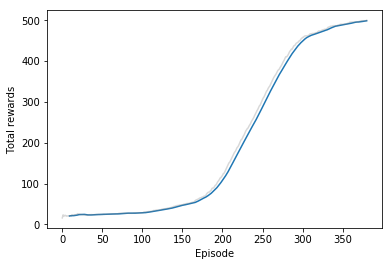

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

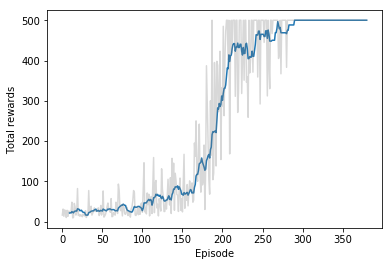

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.